In [3]:
# Making data ready
from sklearn.datasets import make_circles #Used for making 2 concentric circles 

#Make samples
n_samples=1000 #Total no of points for 2 circles

# X cordinates of points Y is label mentioning 1 for inner circle and 0 for Outercircle
X,Y = make_circles(n_samples,
                  noise = 0.03,#a little bit of noise to dots. Noise is makes the data realistic by dealigning some points form the boundries of the circles
                  random_state=42 )#used for maintaining linearity and similarity of random points

In [4]:
print(f"X featres:\n{X[:5]}")
print(f"Y Labels: \n{Y[:5]}")

X featres:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Y Labels: 
[1 1 1 1 0]


In [5]:
#Make a dataframe
import pandas as pd
circles = pd.DataFrame({
                       'x':X[:,0], #X coordinate
                       'y':X[:,1], #Y coocrdinate
                       'labels':Y  #Labels for classification
                      })
circles.head(10)

,x,y,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


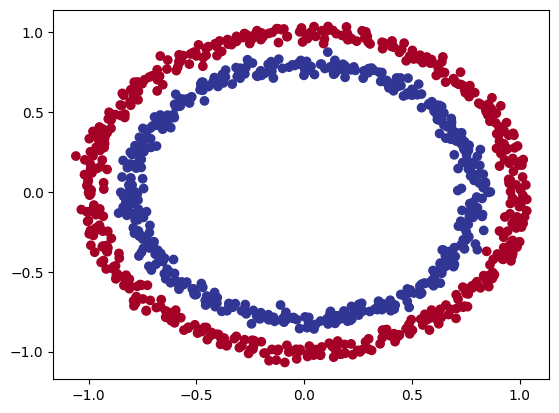

In [6]:
# As labels only have 2 option 0 or 1 it signifies this problem to be a prefecr example of Binary Classification
#Plotting the points for visualiztion

import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=Y, 
            cmap=plt.cm.RdYlBu);

In [7]:
#checking shape
X.shape, Y.shape

((1000, 2), (1000,))

In [8]:
#Shapes should be same
#first create numpy arrays into Tensors
import torch
X = torch.from_numpy(X).type(torch.float32)
Y = torch.from_numpy(Y).type(torch.float32)
X[:5],Y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split
X_Train,X_Test,Y_Train,Y_Test = train_test_split(
                                                 X,
                                                 Y,
                                                test_size = 0.2,
                                                random_state = 42
                                                )

In [10]:
import torch
from torch import nn

#Make device agnostic ready
device = 'cuda' if torch.cuda.is_available() else  'cpu'
device

'cpu'

# Layers in Neural Networks
In neural newtorks layer are created which in turn process the data by createing it in such a way that the model learns it easily and efficiently. For this **nn.Linear** is used, which provides the layers neccesary which are called in the constructor of class where forward passing is written. These layers have 2 parametrs: **in_features** & **out_features**. In **1st layer** the in_features have to match with the actual number of in_features of the dataset. The out_features are selecter by hyper_parameter_tunning. These out_featuers are carry forwarded to **next layer** in_features. These 2 values have to be same. This process is carried on till the last layer of the linear neural network. All these in_features are projected in higher dimensions where the model starts learning. The out_features in **last layer** have to match with number of actual number of out_features.Undersatand it as chef analogy. When helper cheifs are given sugar and flour, they prepar neccesary ingredents which need to be processed for make the cake from them and then pass tit to the lead chef who uses those items passed to prepare the dish.

In [11]:
#Create a class for forward pass
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2, out_features = 5) #in_features of actual data which is then computed to more easier/half processed out_features. These 5 hidden outputs are known as neurons or hidden units.
        self.layer2 = nn.Linear(in_features = 5, out_features=12)#in_features from layer 1 out_features again computed to actual number of out_channels of data provided
        self.layer3 = nn.Linear(in_features = 12, out_features= 1) #Extra layer added after1st execution to check for imporve in accuracy
    
    def forward(self,x):
        #returns the output rom the layer3 recieved
        return self.layer3(self.layer2(self.layer1(x)))

In [12]:
#Create a class for forward pass but adding the factor of non-linearity
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [13]:
#Create instance
modelv1 = CircleModelV1()

In [14]:
#Provide model to device
modelv1.to(device)
modelv1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=12, bias=True)
  (layer3): Linear(in_features=12, out_features=1, bias=True)
)

In [15]:
#Initialize loss function and Optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = modelv1.parameters(),lr=0.1)

In [16]:
#Accuracy Function
def accuracy_score(Y_True,predictions):
    correct = torch.eq(Y_True,predictions).sum().item() #torch.eq() checks for matching of ytest values and predicted values..item() extracts tensor(sum) to sum. Sum: true:1 and false:0
    accuracy = (correct/len(Y_True))*100
    return accuracy

In [17]:
#Training and Testing works same as that for regression
torch.manual_seed(42)

#Set epochs
epochs = 1000

#Push the data to device gpu
X_Train, Y_Train = X_Train.to(device), Y_Train.to(device)
X_Test, Y_Test = X_Test.to(device), Y_Test.to(device)

for epoch in range(epochs):

    #Training .....
    modelv1.train()
    y_logits_train = modelv1(X_Train.to(device)).squeeze()# logits are probability scores meaning how confidant the model is about it's prediction. Higher the value more confident the model is.
    train_prediction = torch.round(torch.sigmoid(y_logits_train)) #Sigmoid converts the logits into readable interpreted data in 1s and 0s.
    loss_train = loss_fn(y_logits_train,Y_Train)
    acc_train = accuracy_score(Y_True = Y_Train,
                        predictions = train_prediction) #accuracty_score() called for calculatin accuracy

    #Optimizer zero grad
    optimizer.zero_grad()

    #Loss backward propogation
    loss_train.backward()

    #Optimizer step
    optimizer.step()

    #Testing .....
    modelv1.eval()
    with torch.inference_mode():

        y_logits_test = modelv1(X_Test.to(device)).squeeze()# logits are probability scores meaning how confidant the model is about it's prediction. Higher the value more confident the model is.
        test_prediction = torch.round(torch.sigmoid(y_logits_test)) #Sigmoid converts the logits into readable interpreted data in 1s and 0s.
        loss_test = loss_fn(y_logits_test,Y_Test)
        acc_test = accuracy_score(Y_True = Y_Test,
                        predictions = test_prediction) #accuracty_score() called for calculatin accuracy

    if epoch%100 == 0:
        print(f'|Epoch  {epoch} |\n| Training Loss { loss_train: .5f} |\n| Accuracy {acc_train:.3f}% |\n| Test Loss {loss_test:.5f} |\n| Test Accuracy {acc_test:.3f}% |')

|Epoch  0 |
| Training Loss  0.69448 |
| Accuracy 50.000% |
| Test Loss 0.69523 |
| Test Accuracy 50.000% |
|Epoch  100 |
| Training Loss  0.69299 |
| Accuracy 51.000% |
| Test Loss 0.69424 |
| Test Accuracy 47.000% |
|Epoch  200 |
| Training Loss  0.69298 |
| Accuracy 51.375% |
| Test Loss 0.69446 |
| Test Accuracy 46.000% |
|Epoch  300 |
| Training Loss  0.69298 |
| Accuracy 51.500% |
| Test Loss 0.69457 |
| Test Accuracy 44.500% |
|Epoch  400 |
| Training Loss  0.69298 |
| Accuracy 51.125% |
| Test Loss 0.69463 |
| Test Accuracy 45.500% |
|Epoch  500 |
| Training Loss  0.69298 |
| Accuracy 51.000% |
| Test Loss 0.69465 |
| Test Accuracy 46.000% |
|Epoch  600 |
| Training Loss  0.69298 |
| Accuracy 51.000% |
| Test Loss 0.69467 |
| Test Accuracy 46.000% |
|Epoch  700 |
| Training Loss  0.69298 |
| Accuracy 51.000% |
| Test Loss 0.69467 |
| Test Accuracy 46.000% |
|Epoch  800 |
| Training Loss  0.69298 |
| Accuracy 51.000% |
| Test Loss 0.69468 |
| Test Accuracy 46.000% |
|Epoch  900 

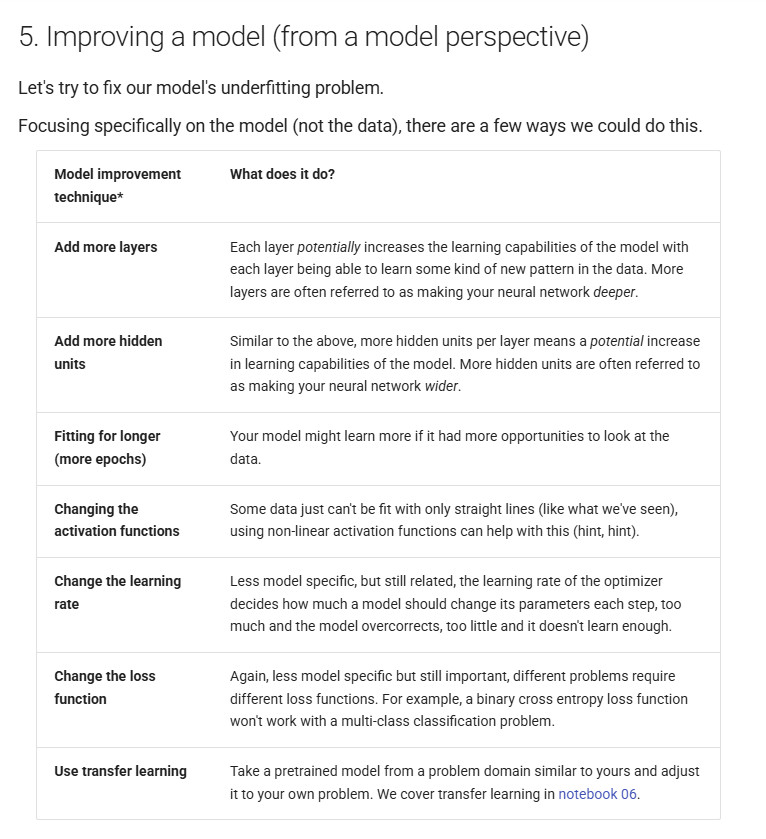

In [18]:
# Repeating all the procedure for CircleModelV2
modelv2 = CircleModelV2()
modelv2.to(device)
modelv2

CircleModelV2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [19]:
#Initialize loss function and Optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = modelv2.parameters(),lr=0.1)

In [20]:
#Training and Testing works same as that for regression
torch.manual_seed(42)

#Set epochs
epochs = 1000

#Push the data to device gpu
X_Train, Y_Train = X_Train.to(device), Y_Train.to(device)
X_Test, Y_Test = X_Test.to(device), Y_Test.to(device)

for epoch in range(epochs):

    #Training .....
    modelv2.train()
    y_logits_train = modelv2(X_Train.to(device)).squeeze()# logits are probability scores meaning how confidant the model is about it's prediction. Higher the value more confident the model is.
    train_prediction = torch.round(torch.sigmoid(y_logits_train)) #Sigmoid converts the logits into readable interpreted data in 1s and 0s.
    loss_train = loss_fn(y_logits_train,Y_Train)
    acc_train = accuracy_score(Y_True = Y_Train,
                        predictions = train_prediction) #accuracty_score() called for calculatin accuracy

    #Optimizer zero grad
    optimizer.zero_grad()

    #Loss backward propogation
    loss_train.backward()

    #Optimizer step
    optimizer.step()

    #Testing .....
    modelv2.eval()
    with torch.inference_mode():

        y_logits_test = modelv2(X_Test.to(device)).squeeze()# logits are probability scores meaning how confidant the model is about it's prediction. Higher the value more confident the model is.
        test_prediction = torch.round(torch.sigmoid(y_logits_test)) #Sigmoid converts the logits into readable interpreted data in 1s and 0s.
        loss_test = loss_fn(y_logits_test,Y_Test)
        acc_test = accuracy_score(Y_True = Y_Test,
                        predictions = test_prediction) #accuracty_score() called for calculatin accuracy

    if epoch%100 == 0 or  epoch == 999:
        print(f'|Epoch  {epoch} |\n| Training Loss { loss_train: .5f} |\n| Accuracy {acc_train:.3f}% |\n| Test Loss {loss_test:.5f} |\n| Test Accuracy {acc_test:.3f}% |')

|Epoch  0 |
| Training Loss  0.69731 |
| Accuracy 50.000% |
| Test Loss 0.69536 |
| Test Accuracy 50.000% |
|Epoch  100 |
| Training Loss  0.69115 |
| Accuracy 50.500% |
| Test Loss 0.69035 |
| Test Accuracy 55.000% |
|Epoch  200 |
| Training Loss  0.68762 |
| Accuracy 59.625% |
| Test Loss 0.68735 |
| Test Accuracy 60.000% |
|Epoch  300 |
| Training Loss  0.68430 |
| Accuracy 61.000% |
| Test Loss 0.68439 |
| Test Accuracy 64.000% |
|Epoch  400 |
| Training Loss  0.68023 |
| Accuracy 64.500% |
| Test Loss 0.68053 |
| Test Accuracy 65.000% |
|Epoch  500 |
| Training Loss  0.67462 |
| Accuracy 64.250% |
| Test Loss 0.67493 |
| Test Accuracy 63.500% |
|Epoch  600 |
| Training Loss  0.66624 |
| Accuracy 63.000% |
| Test Loss 0.66634 |
| Test Accuracy 68.000% |
|Epoch  700 |
| Training Loss  0.65311 |
| Accuracy 67.875% |
| Test Loss 0.65330 |
| Test Accuracy 71.000% |
|Epoch  800 |
| Training Loss  0.63133 |
| Accuracy 75.000% |
| Test Loss 0.63174 |
| Test Accuracy 79.000% |
|Epoch  900 

In [21]:
#Saving the model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path(r'model')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "Circle Points Classification model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=modelv2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: model\Circle Points Classification model.pth
